In [0]:
import torch
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as fun
import torch.optim as optim

In [0]:
generic_transform = transforms.Compose([transforms.ToTensor()])
mnist_train = torchvision.datasets.MNIST(root='./data',train=True,transform=generic_transform,download=True)
mnist_test = torchvision.datasets.MNIST(root='./data',train=False,transform=generic_transform,download=True)

In [106]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(784,400)
    self.fc2 = nn.Linear(400,20)
    self.fc3 = nn.Linear(20,400)
    self.fc4 = nn.Linear(400,784)

  def forward(self,x):
    #encoder
    x=x.view(-1,self.flatten(x))
    x=fun.relu(self.fc1(x))
    x=fun.relu(self.fc2(x))
    #decoder
    x=fun.relu(self.fc3(x))
    x=fun.sigmoid(self.fc4(x))
    return x

  def flatten(self,x):
    size = x.size()[1:]
    num_features=1
    for s in size:
      num_features *= s
    return num_features

net = Net()
print(net)
params = list(net.parameters())
for p in params:
  print(p.shape)


Net(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=784, bias=True)
)
torch.Size([400, 784])
torch.Size([400])
torch.Size([20, 400])
torch.Size([20])
torch.Size([400, 20])
torch.Size([400])
torch.Size([784, 400])
torch.Size([784])


In [0]:
def gaussian(x, mean, stddev):
  noise = torch.FloatTensor(x.data.new(x.size()).normal_(mean, stddev))
  return torch.clamp(x + noise,0,1)
def flatten(x):
  size = x.size()[1:]
  num_features=1
  for s in size:
    num_features *= s
  return num_features

In [112]:
net=Net()
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(),lr=0.001)
n_epochs = 10
delta = 0.0005
grad = 0
pre_grad = -1
pre_loss = -10
losses =[]
for epoch in range(n_epochs):
  if( abs(grad-pre_grad) < delta ):
    print(f'Model converged at epoch={epoch}')
    break
  loss_i=0
  trainloader=torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
  for i, data in enumerate(trainloader,0):
    inputs, _ = data
    noisy_inputs=gaussian(inputs,0,0.5)
    optimizer.zero_grad()
    outputs= net(noisy_inputs)
    loss = criterion(outputs,inputs.view(-1,flatten(inputs)))
    loss.backward()
    optimizer.step()
    pre_grad = grad
    grad = loss.item()-pre_loss
    pre_loss = loss.item()
    loss_i+=np.round(loss.item()*inputs.size(0)/len(trainloader),4)
  losses.append(loss_i)
  print(f'epoch: {epoch+1}, loss: {loss_i}')
print(f'Finished Training at epoch {epoch+1}')
#saving model
PATH = './hw5-dAE.pth'
torch.save(net.state_dict(), PATH)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch: 1, loss: 11.822000000000008
epoch: 2, loss: 9.476400000000027
epoch: 3, loss: 9.020599999999977
epoch: 4, loss: 8.757199999999989
epoch: 5, loss: 8.586699999999999
epoch: 6, loss: 8.465700000000007
epoch: 7, loss: 8.371100000000018
epoch: 8, loss: 8.299800000000024
epoch: 9, loss: 8.238300000000013
epoch: 10, loss: 8.196800000000021
Finished Training at epoch 10


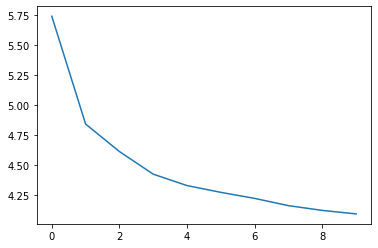

In [109]:
plt.plot(range(epoch+1),losses)

In [113]:
print(loss.grad_fn)  # Crossentropy
print(loss.grad_fn.next_functions[0][0])  # Softmax
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # FC2
print(loss.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[0][0])  # ReLU

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


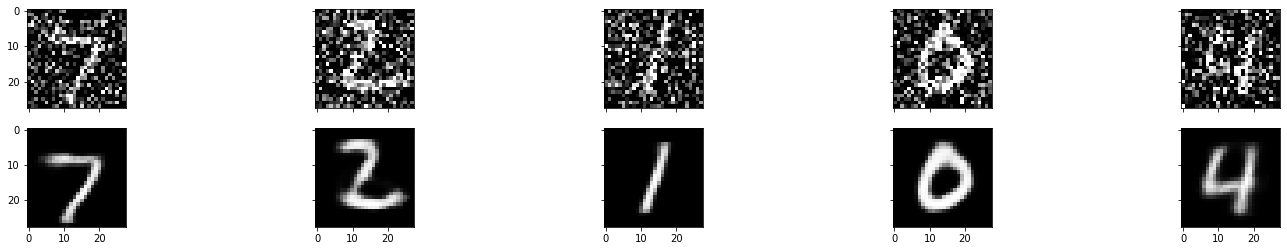

In [115]:
testloader=torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=False)
testnet = Net()
testnet.load_state_dict(torch.load(PATH))
itr = iter(testloader)
itr = iter(itr)
inputs,_ = itr.next()
test_x = gaussian(inputs,0,0.5)
outputs = testnet(test_x)
output = outputs.view(64, 1, 28, 28)
output = output.detach().numpy()
fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for noisy_imgs, row in zip([test_x, output], axes):
    for img, ax in zip(noisy_imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')